Dataset loading and preparing


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import time
%matplotlib inline

In [4]:
data= np.load('/content/drive/MyDrive/SAVEE fusion labelled data.npy', allow_pickle=True)

In [5]:
data_dict = data.item()
video_features = data_dict['video_features']
audio_features = data_dict['audio_features']
labels = data_dict['labels']

In [6]:
print(video_features.shape)
print(audio_features.shape)
print(labels.shape)

(480, 6, 64, 64, 3)
(480, 181)
(480,)


In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
lb = LabelEncoder()
labels = to_categorical(lb.fit_transform(labels))
print(labels.shape)

(480, 7)


In [8]:
audio_features=audio_features.reshape(480,181,1)
print("Audio representation shape:",audio_features.shape)

Audio representation shape: (480, 181, 1)


In [9]:
from sklearn.model_selection import train_test_split
video_features_train, video_features_val,audio_features_train, audio_features_val,labels_train, labels_val = train_test_split(video_features,audio_features,labels, test_size=0.2,random_state=0)
video_features_val, video_features_test,audio_features_val, audio_features_test,labels_val, labels_test = train_test_split(video_features_val,audio_features_val,labels_val, test_size=0.5,random_state=0)

In [10]:
print(video_features_train.shape)
print(video_features_val.shape)
print(video_features_test.shape)
print(audio_features_train.shape)
print(audio_features_val.shape)
print(audio_features_test.shape)
print(labels_train.shape)
print(labels_val.shape)
print(labels_test.shape)

(384, 6, 64, 64, 3)
(48, 6, 64, 64, 3)
(48, 6, 64, 64, 3)
(384, 181, 1)
(48, 181, 1)
(48, 181, 1)
(384, 7)
(48, 7)
(48, 7)


Video model

In [30]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

In [31]:
input_video = Input(shape=(6,64,64,3))
    
conv = ConvLSTM2D(64, 3, activation='relu', padding = 'same')(input_video)
conv= Convolution2D(64, 3, activation='relu', padding = 'same')(conv)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    
conv = Convolution2D(128, 3, activation='relu', padding = 'same')(pool)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
conv = Convolution2D(128, 3, activation='relu', padding = 'same')(pool)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    
conv = Convolution2D(256, 3, activation='relu', padding = 'same')(pool)
#conv3 = Convolution2D(256, 3, activation='relu', padding = 'same')(conv3)
#conv3 = Convolution2D(256, 3, activation='relu', padding = 'same')(conv3)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)

conv = Convolution2D(512, 3, activation='relu', padding = 'same')(pool)
#conv4 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv4)
#conv4 = Convolution2D(512, 3, activation='relu', padding = 'same')(conv4)
pool = MaxPooling2D((2, 2), strides=(2, 2))(conv)
    
output_video = Flatten()(pool)

Audio model

In [32]:
from tensorflow.keras.regularizers import l2
input_audio = Input(shape=(181,1))
    
conv = Convolution1D(64, 10, activation='relu')(input_audio)
conv = Convolution1D(64, 10, activation='relu')(conv)
pool = MaxPooling1D((8))(conv)
conv = Convolution1D(128, 10, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(pool)
pool = MaxPooling1D((8))(conv)
drop = Dropout(0.4)(pool)
    
output_audio = Flatten()(drop)

Concatenation

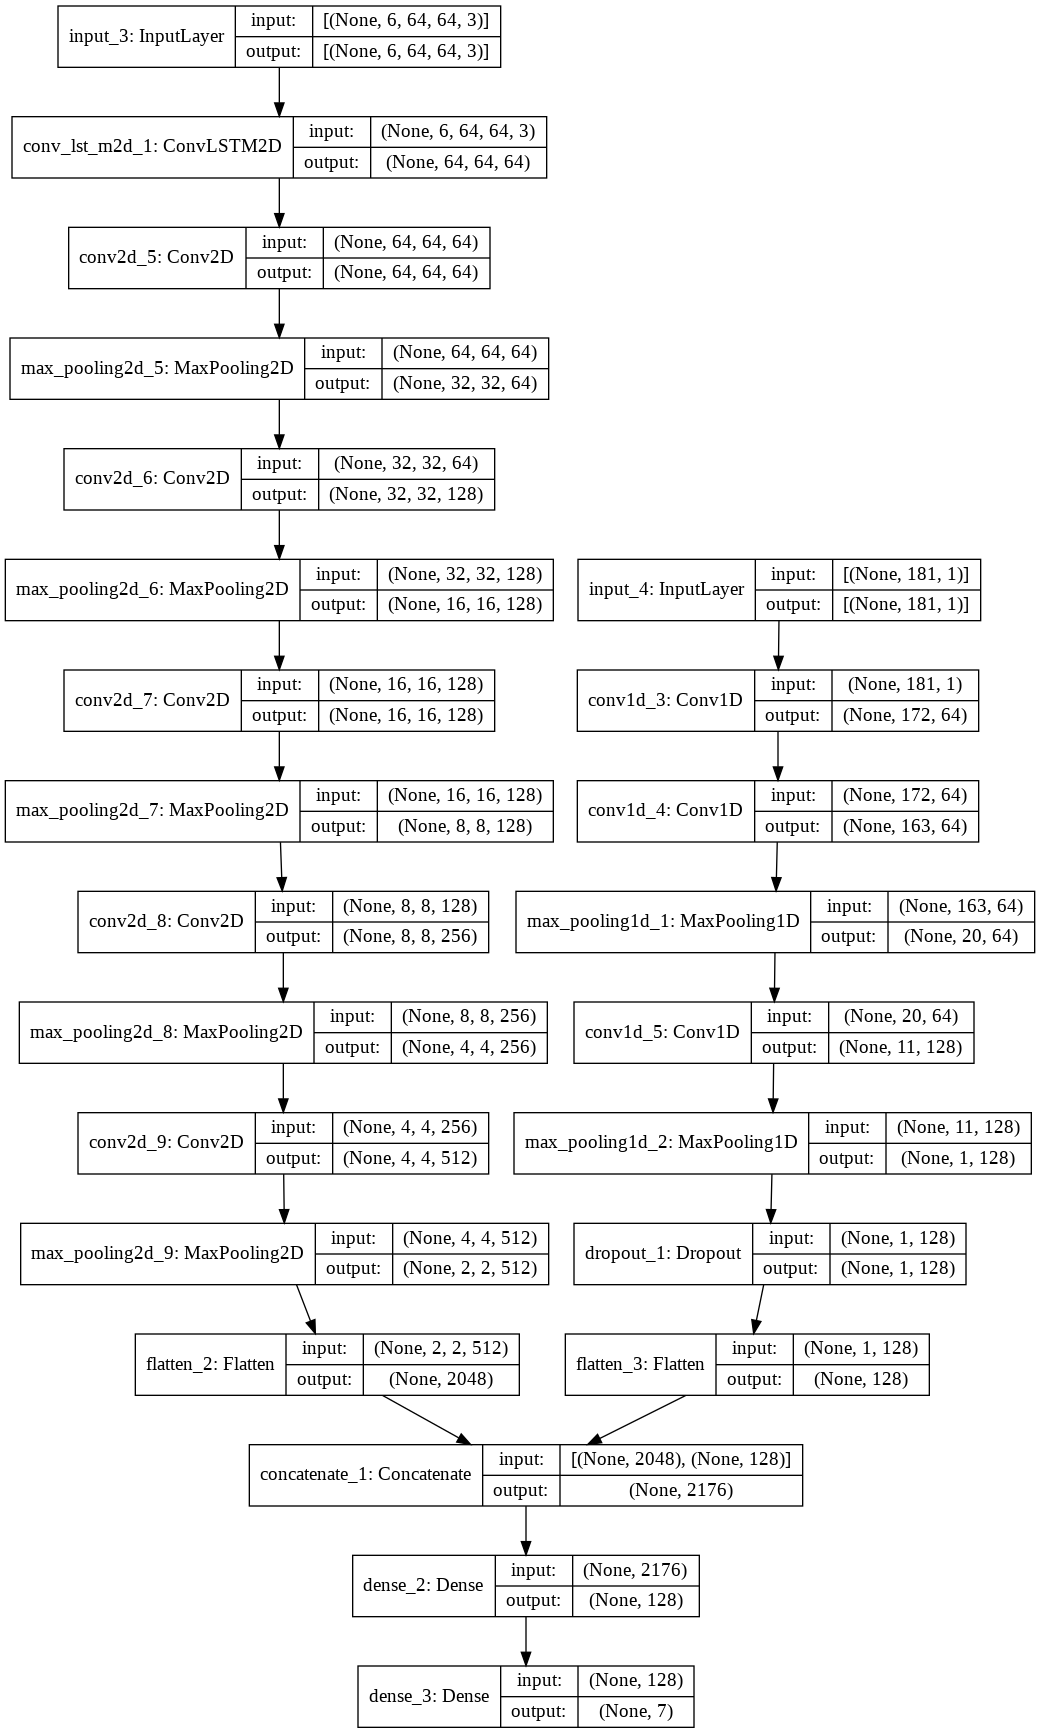

In [33]:
#Now concatenate all the layers to make a multimodal
concatenate = keras.layers.Concatenate()([output_video, output_audio])
final_layer = Dense(128, activation='relu')(concatenate)
y_predict_emotions = Dense(7, activation='softmax')(final_layer)
model = Model(inputs=[input_video, input_audio], outputs=[y_predict_emotions])
tf.keras.utils.plot_model(model, to_file='multimodal model.png', show_shapes=True, show_layer_names=True)

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy', metrics = ['accuracy'])
start=time.time()
history = model.fit([video_features_train,audio_features_train],labels_train,
                    epochs = 120, 
                    batch_size=32,
                    validation_data=([video_features_val,audio_features_val],labels_val))
end=time.time()
train_time_avg=(end-start)/120

Epoch 1/120
12/12 [==============================] - 12s 784ms/step - loss: 2.6473 - accuracy: 0.3151 - val_loss: 2.3531 - val_accuracy: 0.3333
Epoch 2/120
12/12 [==============================] - 9s 721ms/step - loss: 2.2515 - accuracy: 0.3594 - val_loss: 2.1314 - val_accuracy: 0.4167
Epoch 3/120
12/12 [==============================] - 9s 716ms/step - loss: 1.9934 - accuracy: 0.3698 - val_loss: 1.9402 - val_accuracy: 0.4167
Epoch 4/120
12/12 [==============================] - 9s 718ms/step - loss: 1.8427 - accuracy: 0.3932 - val_loss: 1.7285 - val_accuracy: 0.4375
Epoch 5/120
12/12 [==============================] - 9s 715ms/step - loss: 1.7117 - accuracy: 0.4271 - val_loss: 1.6249 - val_accuracy: 0.4583
Epoch 6/120
12/12 [==============================] - 9s 714ms/step - loss: 1.5501 - accuracy: 0.5078 - val_loss: 1.6828 - val_accuracy: 0.3958
Epoch 7/120
12/12 [==============================] - 9s 713ms/step - loss: 1.4852 - accuracy: 0.4948 - val_loss: 1.5710 - val_accuracy: 0.500

In [35]:
start=time.time()
score=model.evaluate([video_features_test,audio_features_test],labels_test)
end=time.time()
test_time=end-start
print("Test loss of the model is - " , score[0])
print("Test accuracy of the model is - " , score[1]*100 , "%")

2/2 [==============================] - 0s 134ms/step - loss: 0.1533 - accuracy: 0.9792
Test loss of the model is -  0.15330761671066284
Test accuracy of the model is -  97.91666865348816 %


In [36]:
print(train_time_avg)
print(test_time)

8.703442581494649
0.5022244453430176


In [37]:
from sklearn.metrics import confusion_matrix
predictions = model.predict([video_features_test,audio_features_test])
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
actual = labels_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
cm = confusion_matrix(actual, predictions,labels=['a', 'd', 'f', 'h', 'n', 'sa', 'su'],normalize='true')
conf_matrix= pd.DataFrame(cm,index=None,columns=None)
conf_matrix.to_csv(r'confusion_matrix.csv', index = None, header=False)

In [38]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['a', 'd', 'f', 'h', 'n', 'sa', 'su']))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00         6
           d       1.00      1.00      1.00         3
           f       1.00      1.00      1.00         4
           h       0.86      1.00      0.92         6
           n       1.00      1.00      1.00        13
          sa       1.00      1.00      1.00         7
          su       1.00      0.89      0.94         9

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



In [39]:
from imblearn.metrics import specificity_score
s=specificity_score(actual,predictions,average='macro')
print(s)

0.9965986394557823


In [40]:
from sklearn.metrics import roc_auc_score
y_score=model.predict([video_features_test,audio_features_test])
auc=roc_auc_score(labels_test, y_score, average='macro',multi_class='ovo')
print(auc)

0.998459212744927


In [41]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
p=precision_score(actual,predictions,average='macro')
r=recall_score(actual,predictions,average='macro')
f=f1_score(actual,predictions,average='macro')
print(p,r,f)

0.979591836734694 0.9841269841269842 0.9806076276664513


In [42]:
from numpy import interp
from sklearn.metrics import roc_curve
fpr = dict()
tpr = dict()
classes=7
y_score=model.predict([video_features_test,audio_features_test])
for i in range(classes):
  fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], y_score[:, i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr

In [43]:
l=[]
for i in range(120):
  l.append(i+1)

In [44]:
from pandas import DataFrame
C = {'epoch no':l,
    'acc train':history.history['accuracy'],
    'acc val':history.history['val_accuracy'],
    'loss train':history.history['loss'],
    'loss val':history.history['val_loss']}
df = DataFrame(C, columns= ['epoch no','acc train','acc val','loss train','loss val'])
export_csv = df.to_csv (r'result1.csv', index = None, header=True) 
print (df)

     epoch no  acc train   acc val  loss train  loss val
0           1   0.315104  0.333333    2.647303  2.353148
1           2   0.359375  0.416667    2.251528  2.131384
2           3   0.369792  0.416667    1.993414  1.940153
3           4   0.393229  0.437500    1.842656  1.728528
4           5   0.427083  0.458333    1.711660  1.624866
..        ...        ...       ...         ...       ...
115       116   1.000000  0.958333    0.047769  0.164767
116       117   0.994792  0.979167    0.055410  0.103714
117       118   1.000000  0.979167    0.035255  0.108767
118       119   1.000000  0.958333    0.034038  0.087095
119       120   1.000000  0.958333    0.029697  0.096566

[120 rows x 5 columns]


In [45]:
C = {
     'train acc':[str(history.history['accuracy'][119])],
     'test acc':[str(score[1])],
     'precision(macro)':[str(p)],
     'recall(macro)':[str(r)],
     'f1(macro)':[str(f)],
     'specificity(macro)':[str(s)],
     'AUC(macro)':[str(auc)],
     'average train time(s)':[str(train_time_avg)],
     'test time(s)':[str(test_time)],}
df = DataFrame(C, columns= ['train acc','test acc','precision(macro)','recall(macro)','f1(macro)','specificity(macro)','AUC(macro)','average train time(s)','test time(s)'])
export_csv = df.to_csv (r'result2.csv', index = None, header=True) 
print (df)

  train acc            test acc  ... average train time(s)        test time(s)
0       1.0  0.9791666865348816  ...     8.703442581494649  0.5022244453430176

[1 rows x 9 columns]


In [46]:
C = {
     'TPR(macro)': tpr['macro'],
     'FPR(macro)': fpr['macro']}
df = DataFrame(C, columns= ['TPR(macro)','FPR(macro)'])
export_csv = df.to_csv (r'result3.csv', index = None, header=True) 
print (df)

   TPR(macro)  FPR(macro)
0    0.936508    0.000000
1    0.984127    0.023810
2    1.000000    0.025641
3    1.000000    1.000000
